In [1]:

#view image in breastmnist file in dataset folder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os

dfile = '../Datasets/breastmnist.npz'
if not os.path.exists(dfile):
	raise FileNotFoundError(f"The file {dfile} does not exist.")
data_breastmnist = np.load(dfile)



In [2]:
#Exploring the breastmnist dataset
breastmnist_train_images = data_breastmnist['train_images']
breastmnist_train_labels = data_breastmnist['train_labels']

breastmnist_val_images = data_breastmnist['val_images']
breastmnist_val_labels = data_breastmnist['val_labels']

breastmnist_test_images = data_breastmnist['test_images']
breastmnist_test_labels = data_breastmnist['test_labels']

#Inspect the data
print(f"Train images: {breastmnist_train_images.shape}")
print(f"Train labels: {breastmnist_train_labels.shape}")

#Summary statistics of the labels
unique, counts = np.unique(breastmnist_train_labels, return_counts=True)
print(dict(zip(unique, counts)))



Train images: (546, 28, 28)
Train labels: (546, 1)
{0: 147, 1: 399}


In [3]:
#Normalize the images
breastmnist_train_images = breastmnist_train_images.astype('float32') / 255
breastmnist_val_images = breastmnist_val_images.astype('float32') / 255
breastmnist_test_images = breastmnist_test_images.astype('float32') / 255

#Flatten the images for the model
breastmnist_train_images = breastmnist_train_images.reshape((-1, 28*28))
breastmnist_val_images = breastmnist_val_images.reshape((-1, 28*28))
breastmnist_test_images = breastmnist_test_images.reshape((-1, 28*28))

#Convert to a pandas dataframe
breastmnist_train_images = pd.DataFrame(breastmnist_train_images)
breastmnist_val_images = pd.DataFrame(breastmnist_val_images)
breastmnist_test_images = pd.DataFrame(breastmnist_test_images)

#Add the labels to the dataframes
breastmnist_train_images['label'] = breastmnist_train_labels
breastmnist_val_images['label'] = breastmnist_val_labels
breastmnist_test_images['label'] = breastmnist_test_labels



In [4]:
# Train a Gradient Boosting Classifier and a Random Forest Classifier on the breastmnist dataset
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
gbc_predictions = gbc.predict(breastmnist_val_images.drop(columns='label'))


#Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
rfc_predictions = rfc.predict(breastmnist_val_images.drop(columns='label'))



Classification report for Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78        21
           1       0.89      0.98      0.93        57

    accuracy                           0.90        78
   macro avg       0.91      0.82      0.86        78
weighted avg       0.90      0.90      0.89        78

Classification report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       0.87      0.95      0.91        57

    accuracy                           0.86        78
   macro avg       0.84      0.78      0.81        78
weighted avg       0.86      0.86      0.85        78



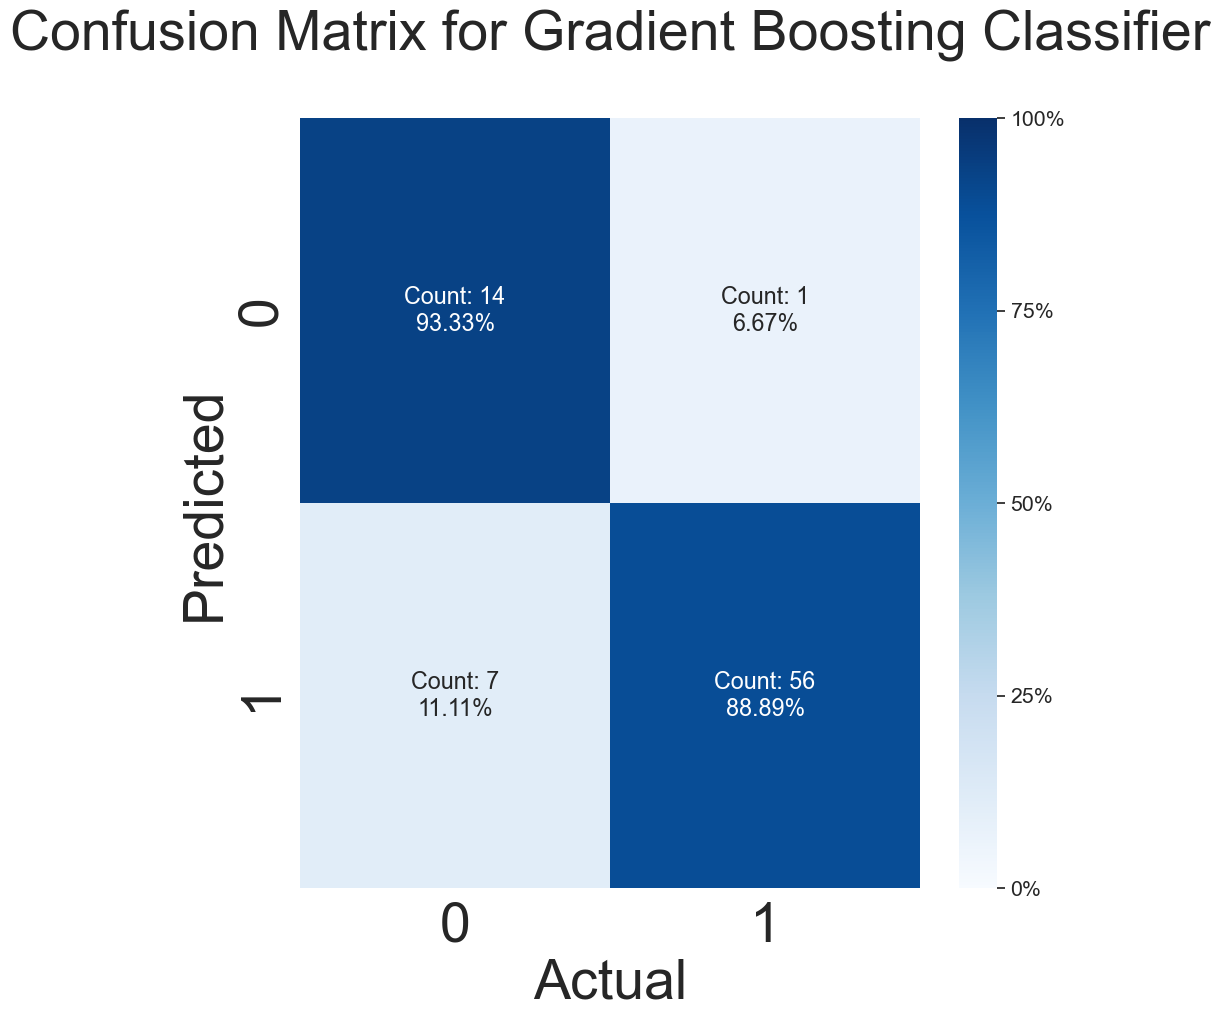

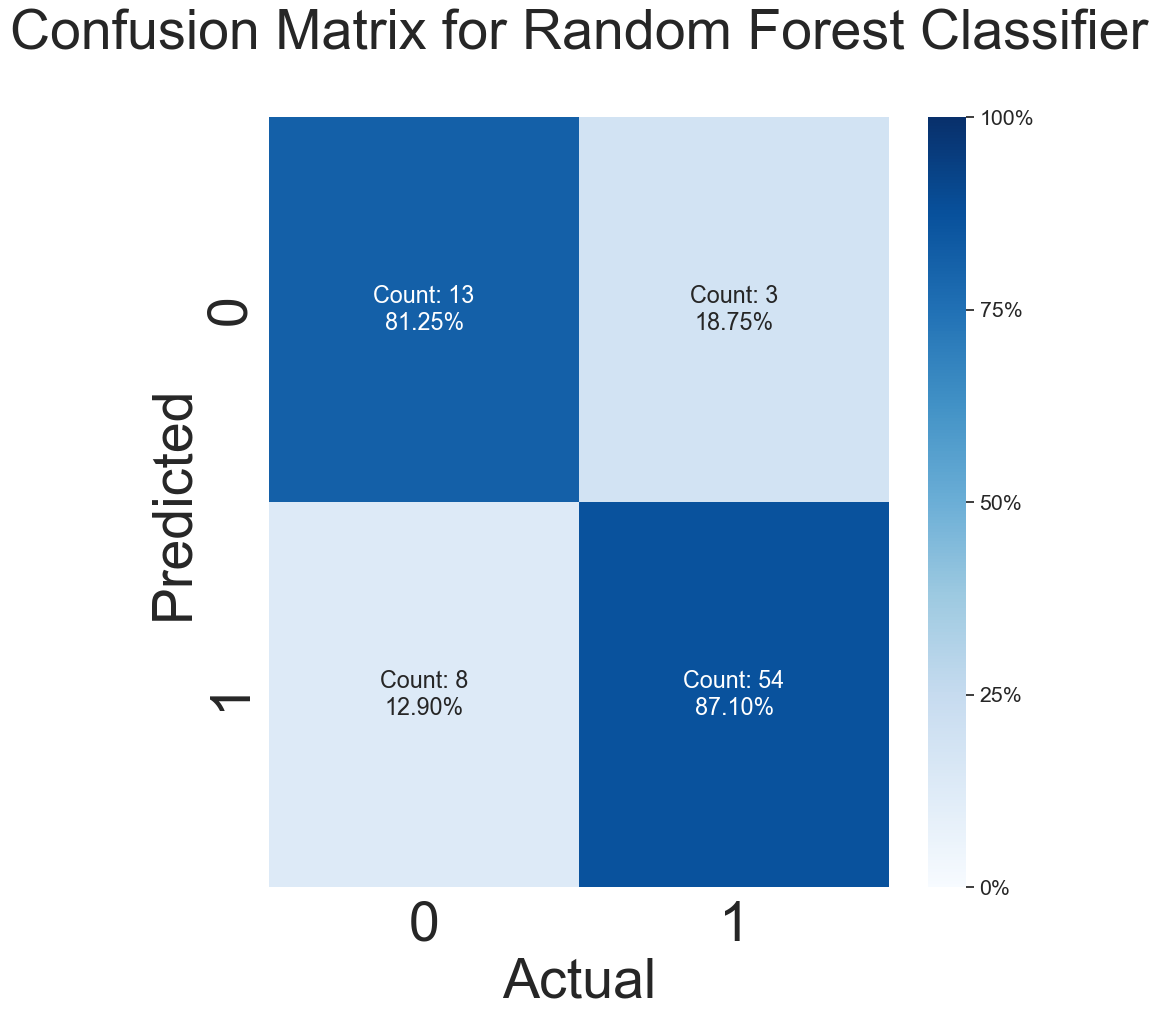

In [35]:
import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

model_evaluation(breastmnist_val_images['label'], gbc_predictions, 'Gradient Boosting Classifier')
model_evaluation(breastmnist_val_images['label'], rfc_predictions, 'Random Forest Classifier')


In [36]:
# Tune the GBC model using GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(gbc, param_grid, cv=2)
grid_search.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
print(f'Best parameters for the Gradient Boosting Classifier: {grid_search.best_params_}')


Best parameters for the Gradient Boosting Classifier: {'max_depth': 3, 'n_estimators': 100}


In [72]:
# Tune the RFC model using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150]
}
grid_search = GridSearchCV(rfc, param_grid, cv=3)
grid_search.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
print(f'Best parameters for the Random Forest Classifier: {grid_search.best_params_}')


Best parameters for the Random Forest Classifier: {'n_estimators': 150}


In [ ]:

# Adjust the models with the best parameters
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbc.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])

rfc = RandomForestClassifier(n_estimators=150)
rfc.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])

# Evaluate the models on the test sets
gbc_test_predictions = gbc.predict(breastmnist_test_images.drop(columns='label'))
rfc_test_predictions = rfc.predict(breastmnist_test_images.drop(columns='label'))


Classification report for Gradient Boosting Classifier on Test data:
              precision    recall  f1-score   support

           0       0.65      0.48      0.55        42
           1       0.82      0.90      0.86       114

    accuracy                           0.79       156
   macro avg       0.73      0.69      0.70       156
weighted avg       0.78      0.79      0.78       156

Classification report for Random Forest Classifier on Test data:
              precision    recall  f1-score   support

           0       0.71      0.40      0.52        42
           1       0.81      0.94      0.87       114

    accuracy                           0.79       156
   macro avg       0.76      0.67      0.69       156
weighted avg       0.78      0.79      0.77       156



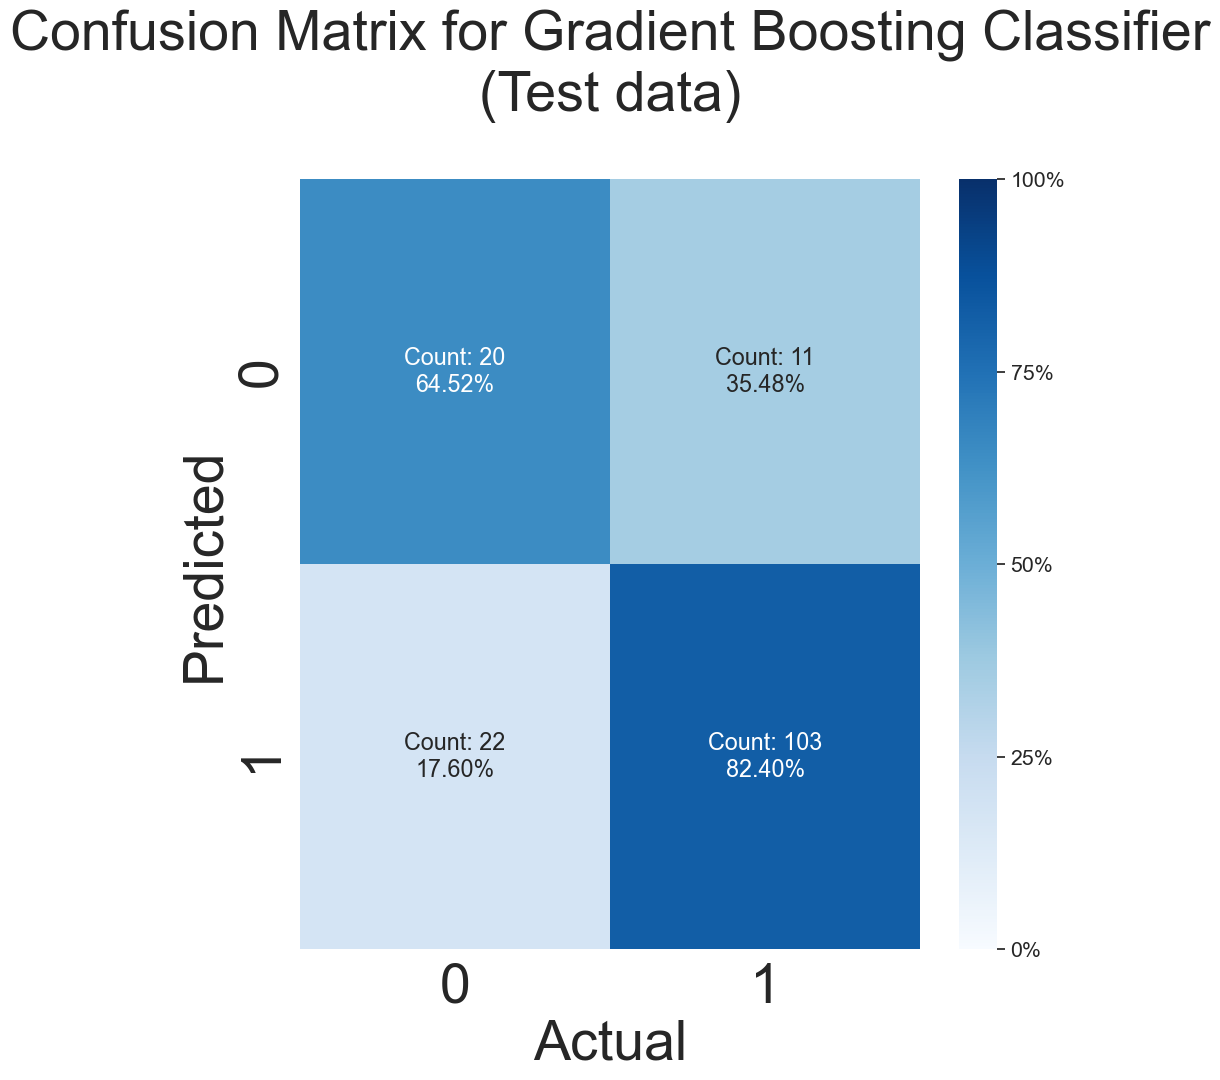

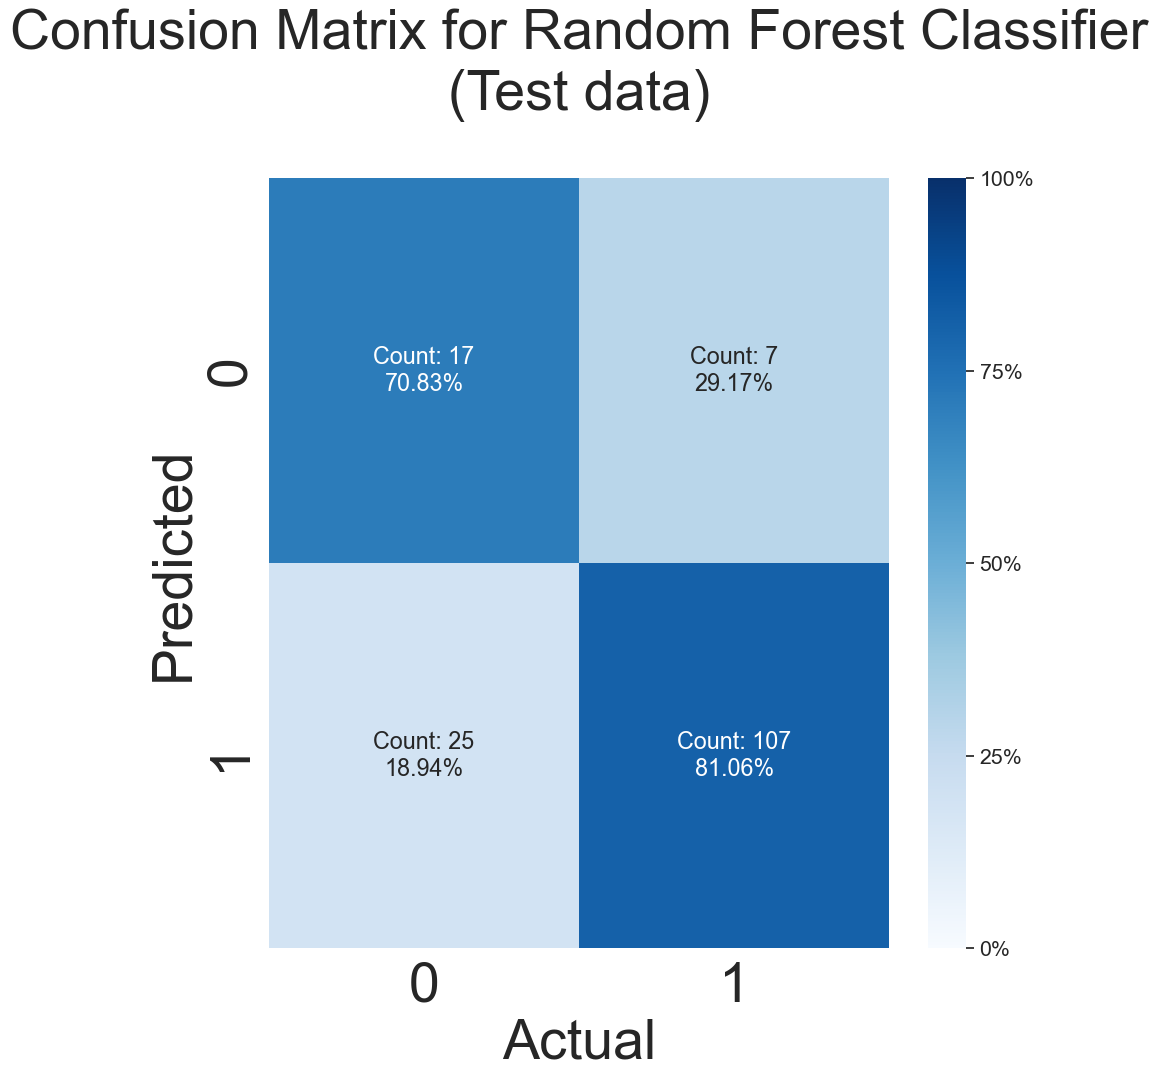

In [41]:
import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

# Accuracy of the Gradient Boost Classifier model on the test set
model_evaluation(breastmnist_test_images['label'], gbc_test_predictions, 'Gradient Boosting Classifier', 'Test')
# Accuracy of the Random Forest Classifier model on the test set
model_evaluation(breastmnist_test_images['label'], rfc_test_predictions, 'Random Forest Classifier', 'Test')

c:\Users\phili\miniconda3\envs\MLS_1\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification report for AdaBoost Classifier on Validation data:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        21
           1       0.88      0.89      0.89        57

    accuracy                           0.83        78
   macro avg       0.79      0.78      0.78        78
weighted avg       0.83      0.83      0.83        78

Classification report for RUSBoost Classifier on Validation data:
              precision    recall  f1-score   support

           0       0.62      0.76      0.68        21
           1       0.90      0.82      0.86        57

    accuracy                           0.81        78
   macro avg       0.76      0.79      0.77        78
weighted avg       0.83      0.81      0.81        78



c:\Users\phili\miniconda3\envs\MLS_1\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\phili\miniconda3\envs\MLS_1\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\phili\miniconda3\envs\MLS_1\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the futu

Classification report for Balanced Random Forest Classifier on Validation data:
              precision    recall  f1-score   support

           0       0.53      0.76      0.63        21
           1       0.90      0.75      0.82        57

    accuracy                           0.76        78
   macro avg       0.71      0.76      0.72        78
weighted avg       0.80      0.76      0.77        78



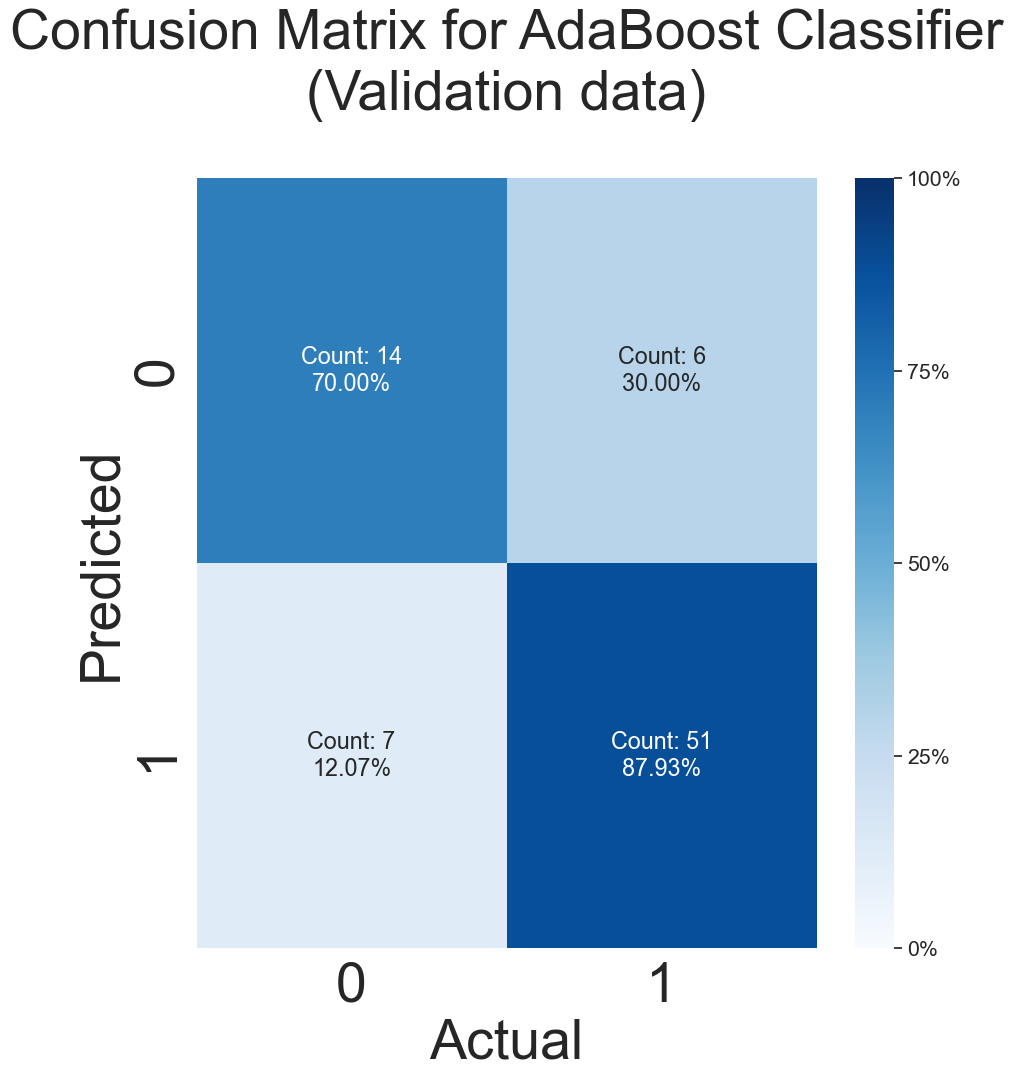

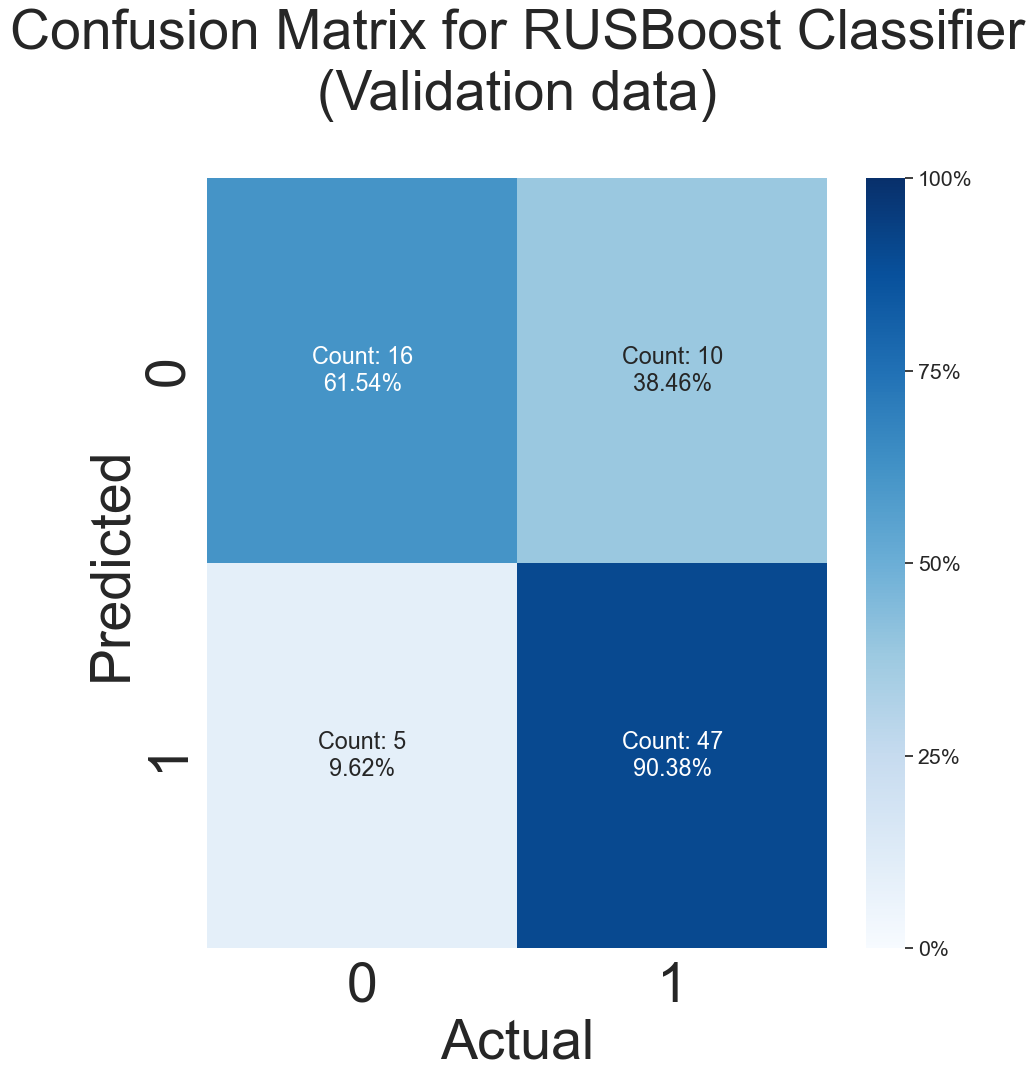

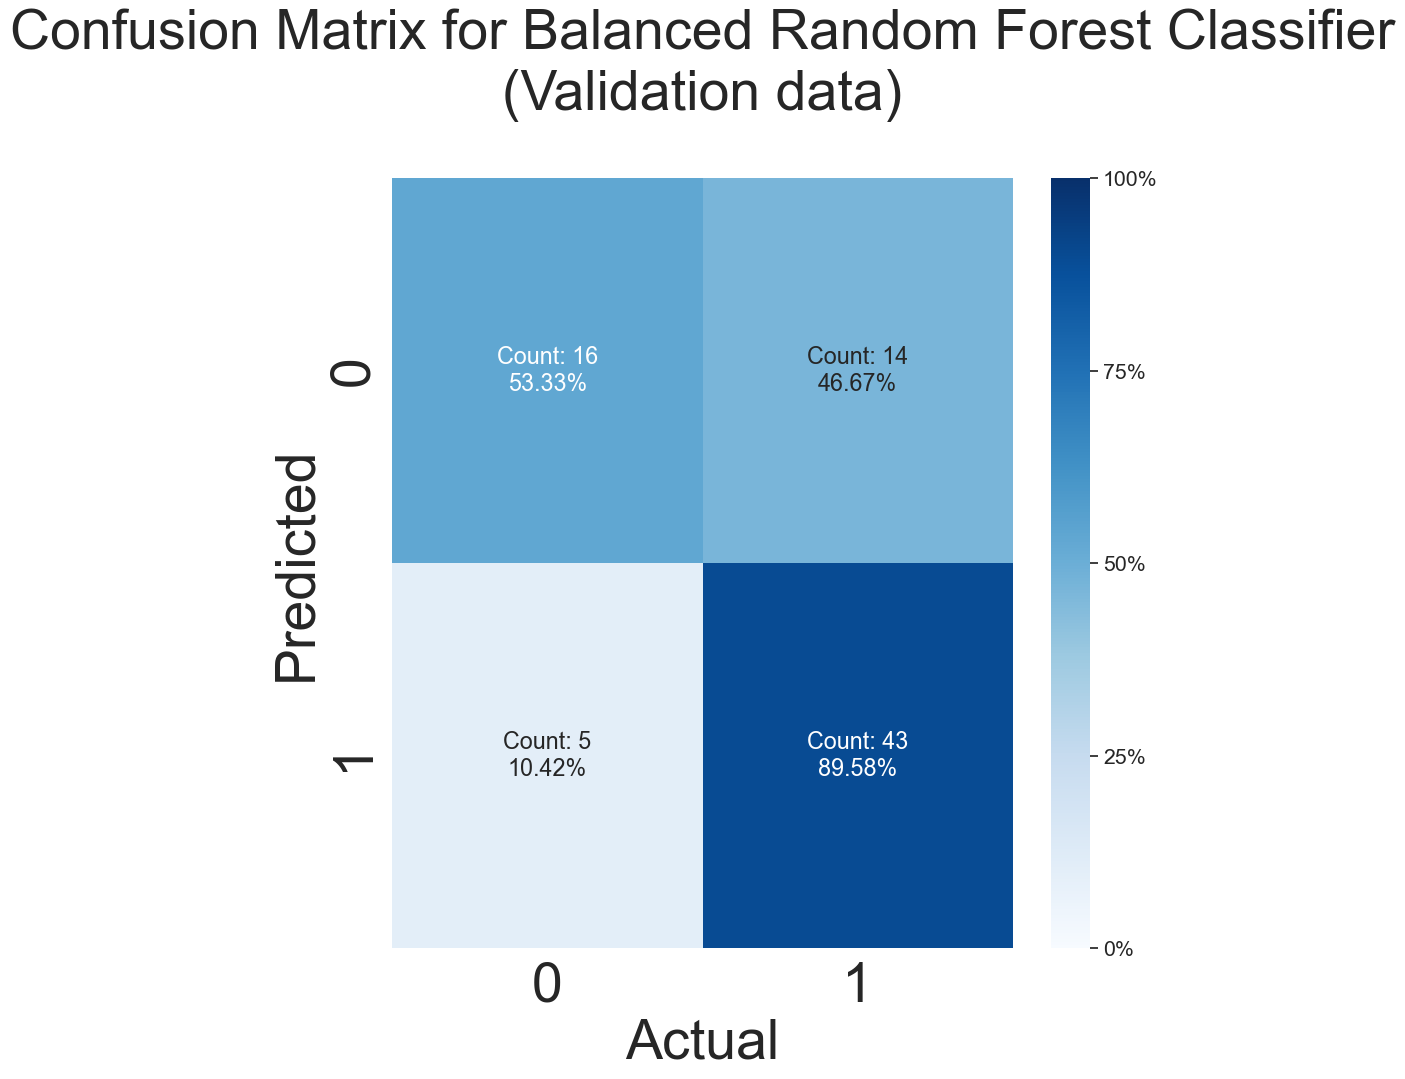

In [ ]:
# Build RUSBoost Classifier which is a combination of Random Undersampling and AdaBoost
from imblearn.ensemble import RUSBoostClassifier
from sklearn.datasets import make_classification

from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
ada_val_predictions = ada.predict(breastmnist_val_images.drop(columns='label'))
model_evaluation(breastmnist_val_images['label'], ada_val_predictions, 'AdaBoost Classifier', 'Validation')

rusboost = RUSBoostClassifier(n_estimators=100, algorithm='SAMME.R',
                              random_state=0)
rusboost.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
rusboost_val_predictions = rusboost.predict(breastmnist_val_images.drop(columns='label'))
model_evaluation(breastmnist_val_images['label'], rusboost_val_predictions, 'RUSBoost Classifier', 'Validation')

# Build BalancedRandomForestClassifier which is a combination of Random Forest and bootstrap sampling
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
brf_val_predictions = brf.predict(breastmnist_val_images.drop(columns='label'))
model_evaluation(breastmnist_val_images['label'], brf_val_predictions, 'Balanced Random Forest Classifier', 'Validation')



(78,)
Classification report for SVC with linear kernel on Validation data:
              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.85      0.96      0.90        57

    accuracy                           0.85        78
   macro avg       0.85      0.74      0.77        78
weighted avg       0.85      0.85      0.83        78



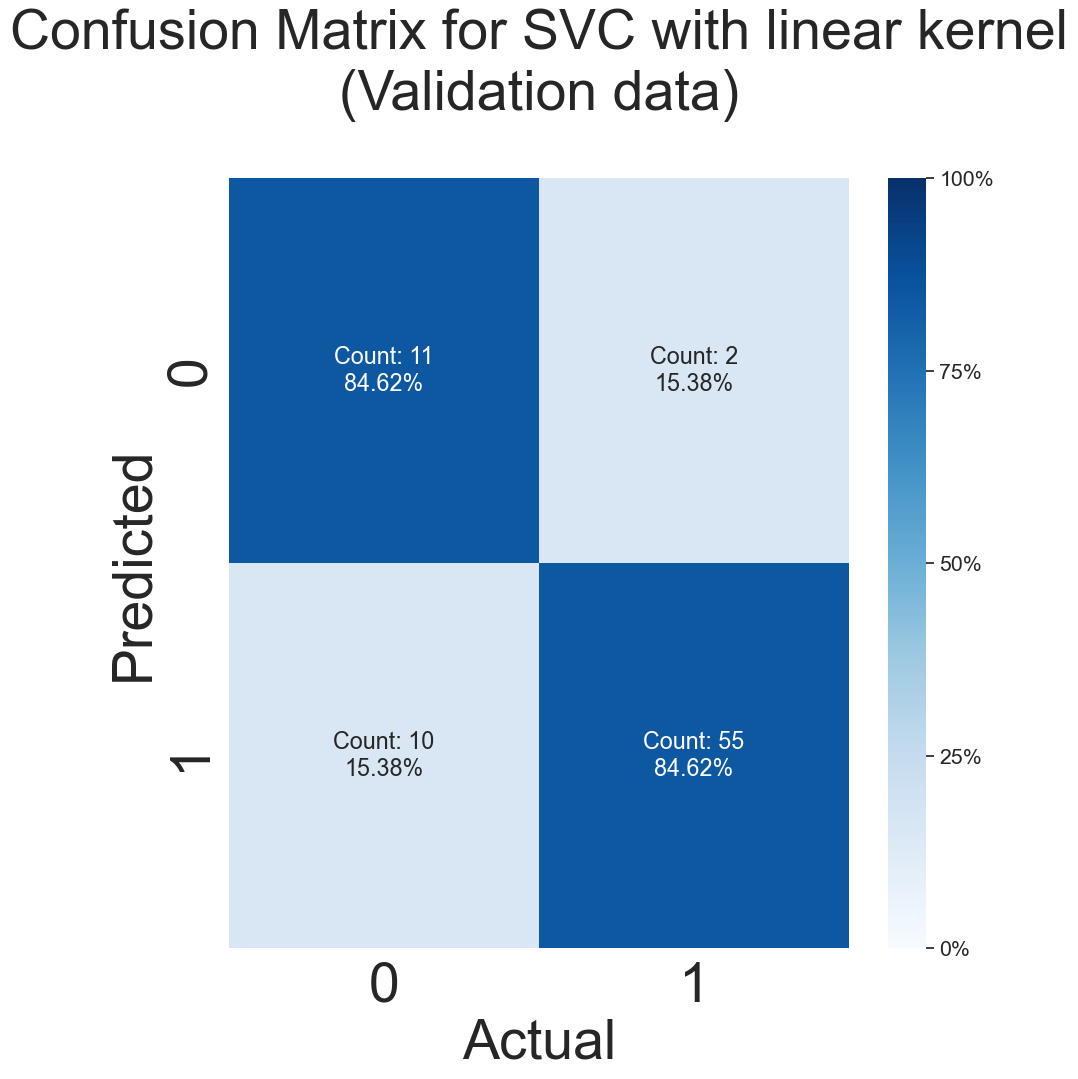

In [75]:
# Build a SVC model with a linear kernel on the breastmnist dataset
from sklearn.svm import SVC

print(breastmnist_val_images['label'].shape)

svc = SVC(kernel='linear')
svc.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
svc_predictions = svc.predict(breastmnist_val_images.drop(columns='label'))
model_evaluation(breastmnist_val_images['label'], svc_predictions, 'SVC with linear kernel', 'Validation')

{'linear': 0.8330984348342111, 'poly': 0.8330984348342111, 'rbf': 0.7931623931623931, 'sigmoid': 0.6108946697181991}
Classification report for SVC with linear on Validation data:
              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.85      0.96      0.90        57

    accuracy                           0.85        78
   macro avg       0.85      0.74      0.77        78
weighted avg       0.85      0.85      0.83        78



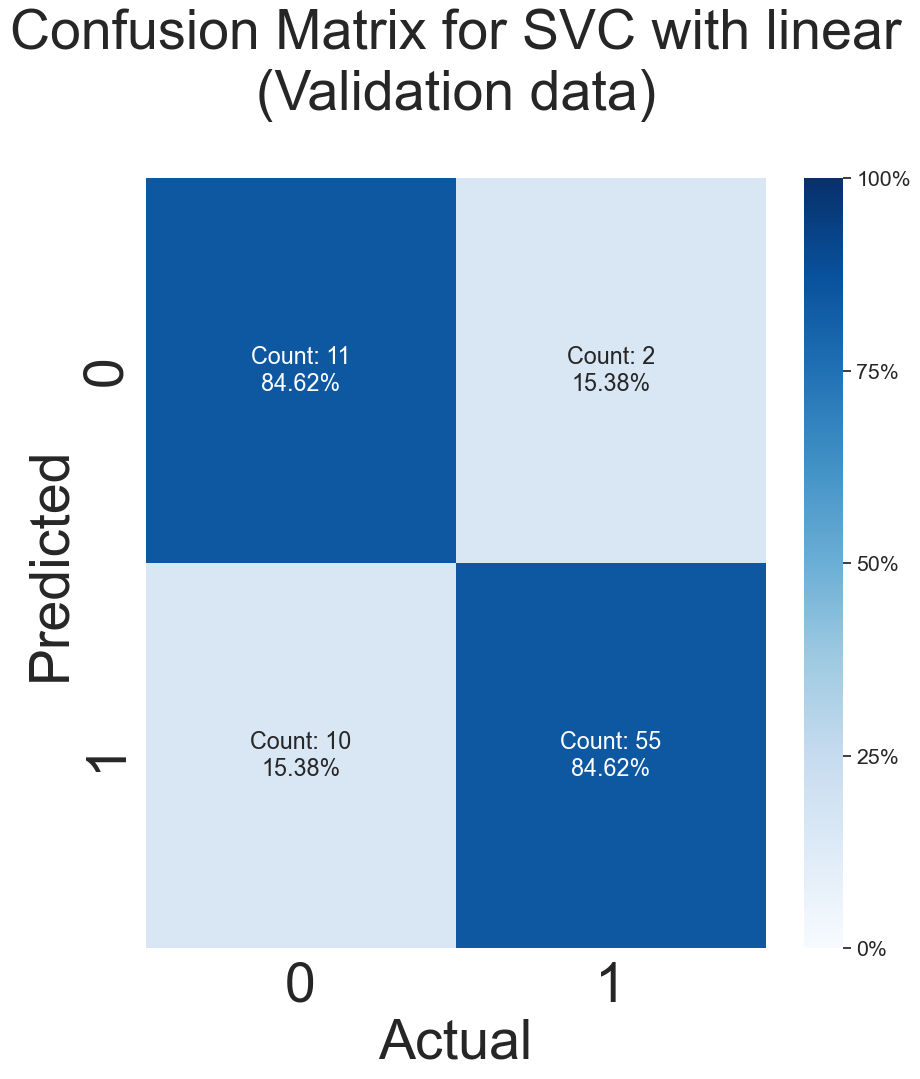

In [ ]:
# Tune the SVC model by using different kernels
param_grid = ['linear', 'poly', 'rbf', 'sigmoid']
f1_score = {}
svc_pred_dict = {}

for k in param_grid:
    svc_tune = SVC(kernel=k)
    svc_tune.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
    svc_pred_dict[k] = svc_tune.predict(breastmnist_val_images.drop(columns='label'))
    f1_score[k] = classification_report(breastmnist_val_images['label'], svc_pred_dict[k], output_dict=True)['weighted avg']['f1-score']

best_kernel = max(f1_score, key=f1_score.get)
model_evaluation(breastmnist_val_images['label'], svc_pred_dict[best_kernel], f'SVC with {best_kernel}', 'Validation')


Classification report for Gradient Boosting Classifier on Test data:
              precision    recall  f1-score   support

           0       0.65      0.48      0.55        42
           1       0.82      0.90      0.86       114

    accuracy                           0.79       156
   macro avg       0.73      0.69      0.70       156
weighted avg       0.78      0.79      0.78       156



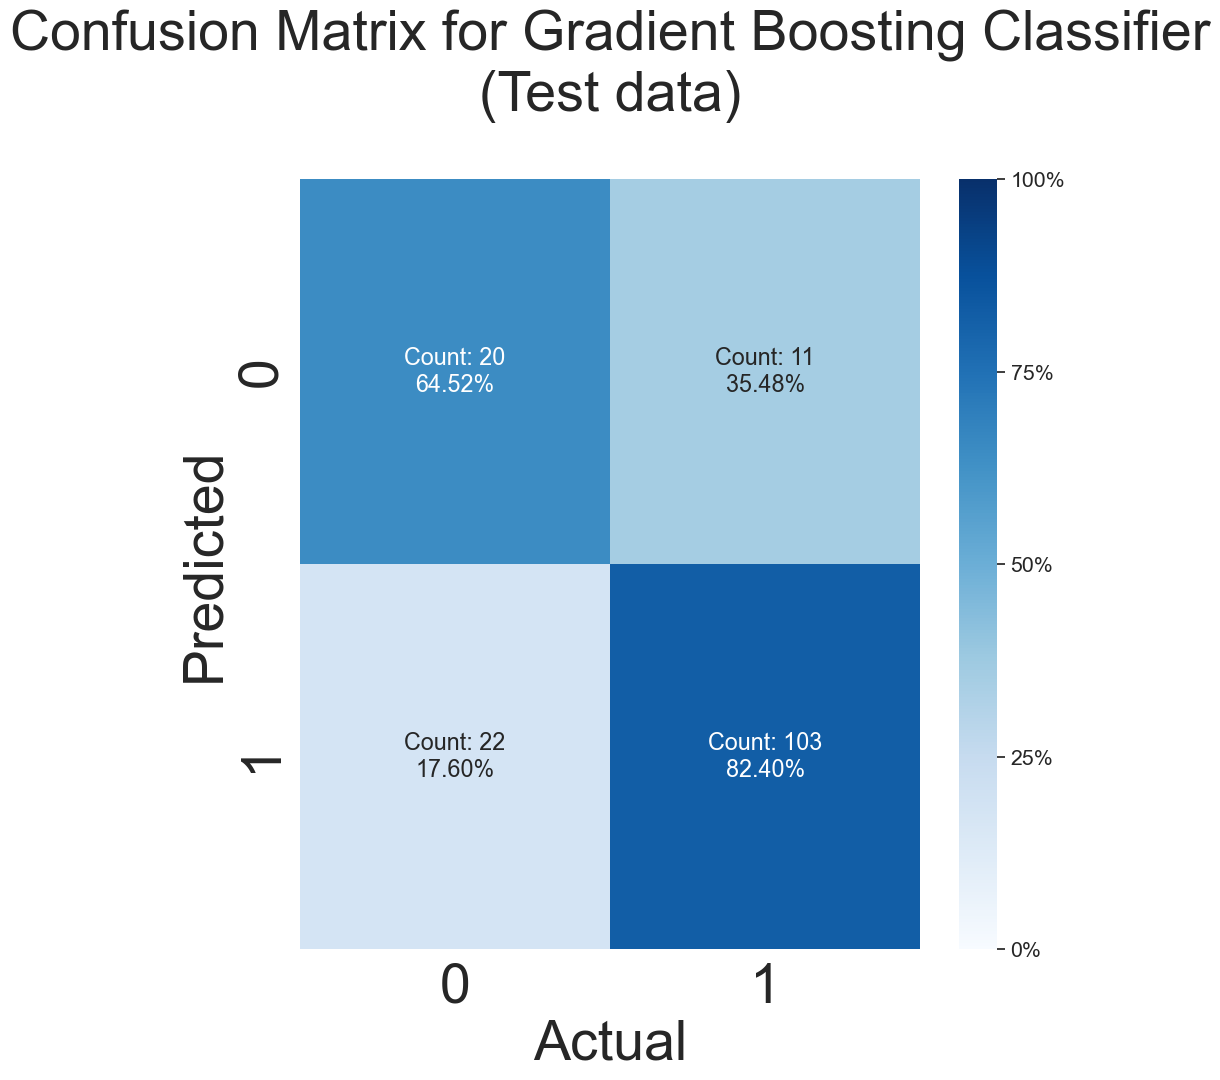

In [58]:
# Evaluate the best Ensemble model on the test set
gbc_test_predictions = gbc.predict(breastmnist_test_images.drop(columns='label'))
model_evaluation(breastmnist_test_images['label'], gbc_test_predictions, 'Gradient Boosting Classifier', 'Test')

Classification report for SVC with linear on Test data:
              precision    recall  f1-score   support

           0       0.62      0.50      0.55        42
           1       0.83      0.89      0.86       114

    accuracy                           0.78       156
   macro avg       0.72      0.69      0.70       156
weighted avg       0.77      0.78      0.77       156



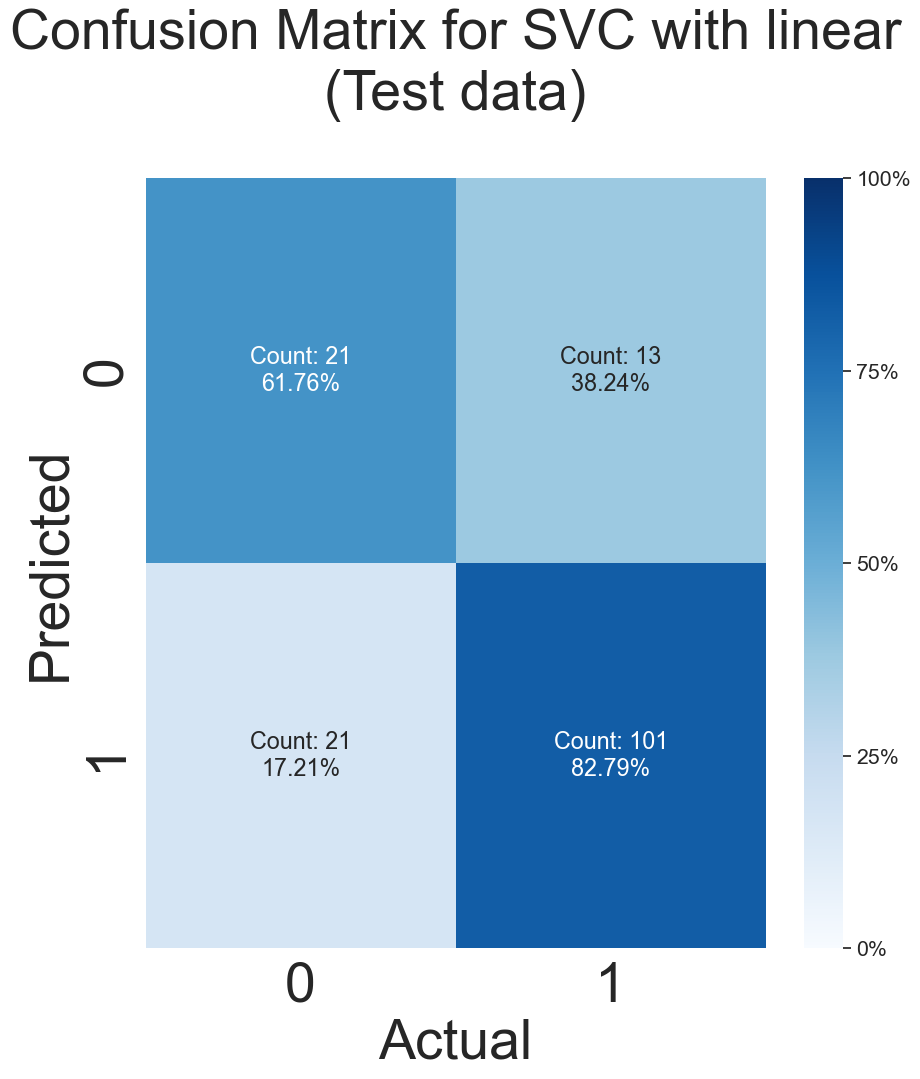

In [60]:
# Use the best kernel to evaluate the model on the test set
svc = SVC(kernel=best_kernel)
svc.fit(breastmnist_train_images.drop(columns='label'), breastmnist_train_images['label'])
svc_test_predictions = svc.predict(breastmnist_test_images.drop(columns='label'))
model_evaluation(breastmnist_test_images['label'], svc_test_predictions, f'SVC with {best_kernel}', 'Test')

(156, 785)
(156, 2)
(156, 785)
(156, 5)
(156, 785)
(156, 10)
(156, 785)
(156, 20)
(156, 785)
(156, 50)
Classification report for Gradient Boosting Classifier with PCA (n=20) on Validation data:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78        21
           1       0.89      0.98      0.93        57

    accuracy                           0.90        78
   macro avg       0.91      0.82      0.86        78
weighted avg       0.90      0.90      0.89        78



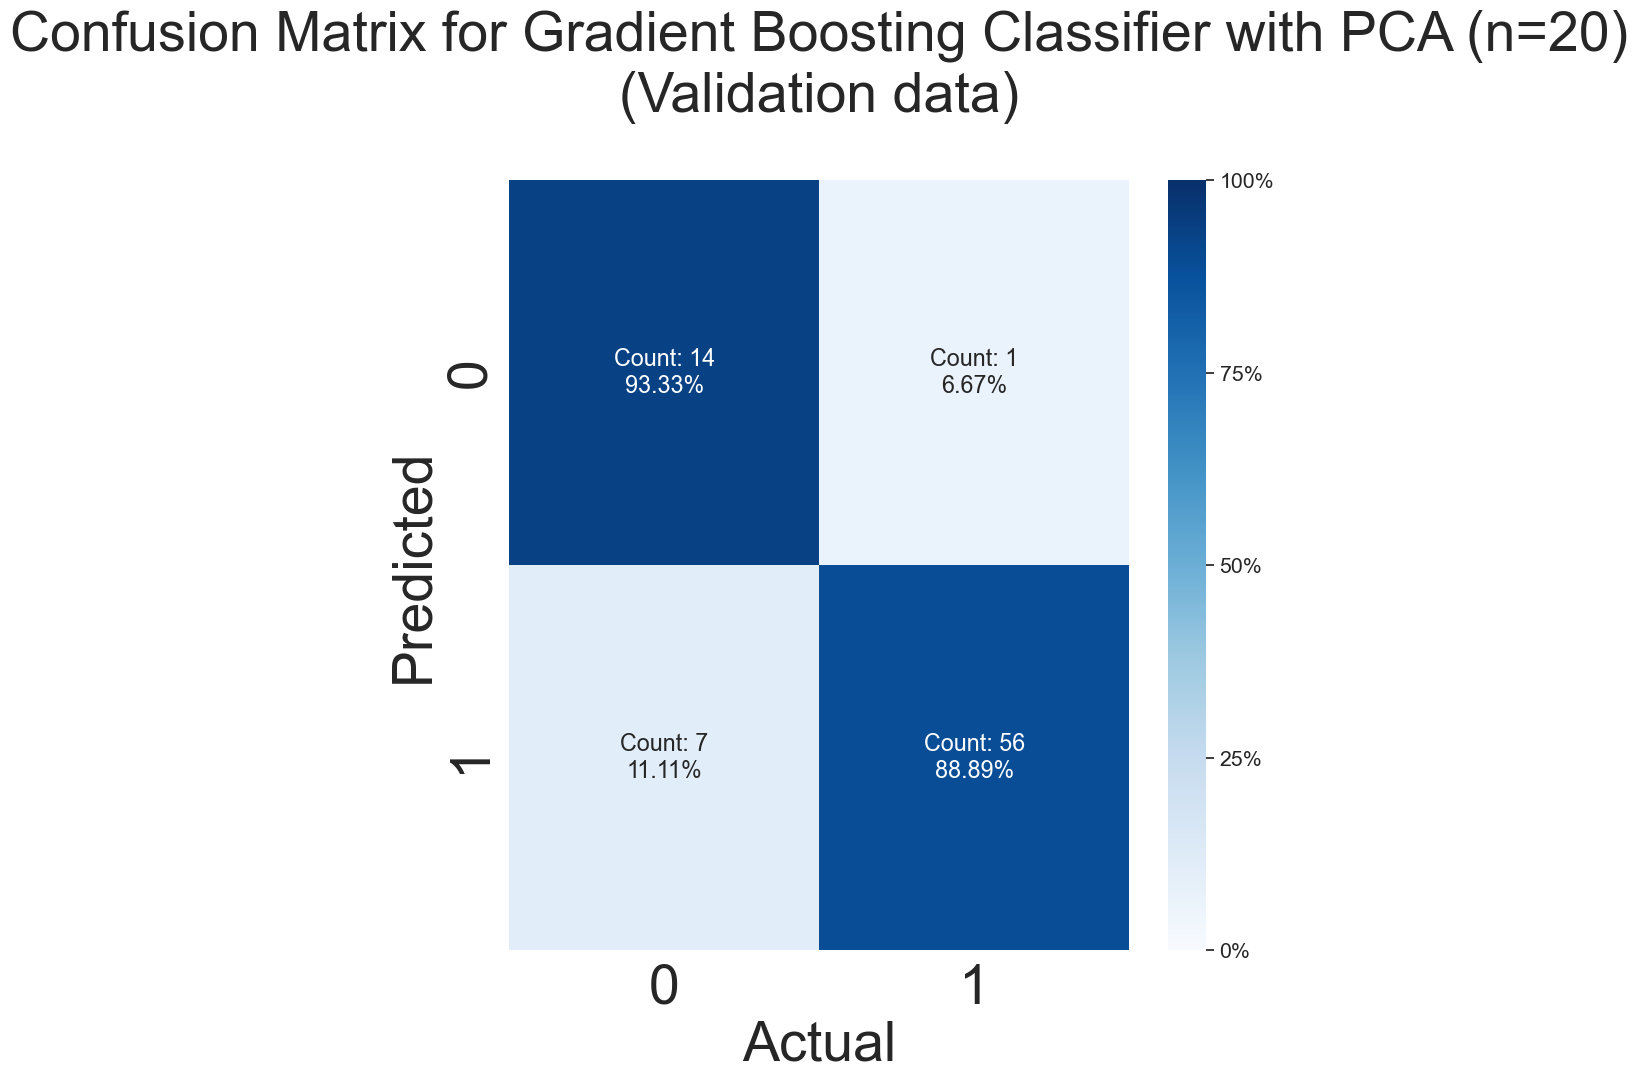

In [ ]:

# Test PCA on the breastmnist dataset for the Gradient Boosting Classifier model
n_of_components = [5, 10, 20, 50, 100]
f1_score_PCA = {}
gbc_pred_dict_PCA = {}

for n in n_of_components:
    pca = PCA(n_components=n)
    breastmnist_train_images_pca = pca.fit_transform(breastmnist_train_images.drop(columns='label'))
    breastmnist_val_images_pca = pca.transform(breastmnist_val_images.drop(columns='label'))
    breastmnist_test_images_pca = pca.transform(breastmnist_test_images.drop(columns='label'))

    gbc_PCA = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    gbc_PCA.fit(breastmnist_train_images_pca, breastmnist_train_images['label'])
    gbc_PCA_predictions = gbc_PCA.predict(breastmnist_val_images_pca)
    gbc_pred_dict_PCA[n] = gbc_PCA_predictions
    f1_score_PCA[n] = classification_report(breastmnist_val_images['label'], gbc_PCA_predictions, output_dict=True)['weighted avg']['f1-score']

best_n = max(f1_score_PCA, key=f1_score_PCA.get)
model_evaluation(breastmnist_val_images['label'], gbc_pred_dict_PCA[best_n], f'Gradient Boosting Classifier with PCA (n={best_n})', 'Validation')

    


Classification report for Gradient Boosting Classifier with PCA (n=20) on Test data:
              precision    recall  f1-score   support

           0       0.64      0.33      0.44        42
           1       0.79      0.93      0.85       114

    accuracy                           0.77       156
   macro avg       0.71      0.63      0.65       156
weighted avg       0.75      0.77      0.74       156



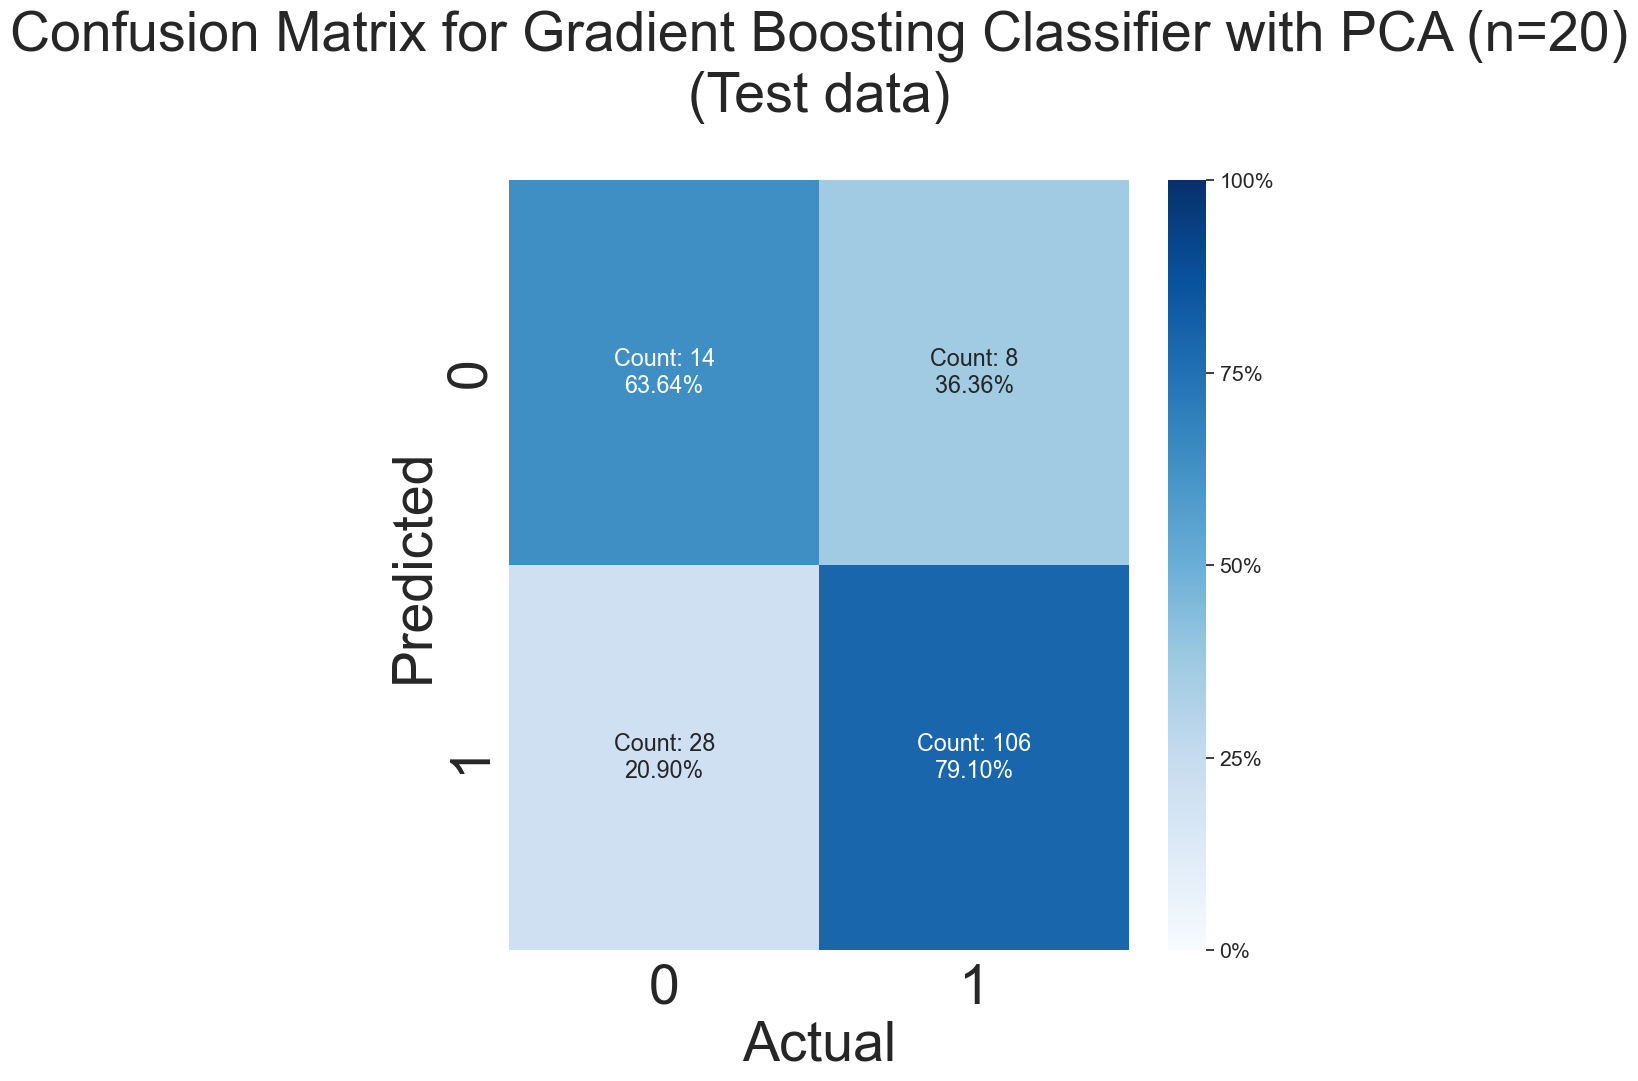

In [64]:
# Evaluate the best PCA model on the test set
pca = PCA(n_components=best_n)
breastmnist_train_images_pca = pca.fit_transform(breastmnist_train_images.drop(columns='label'))
breastmnist_val_images_pca = pca.transform(breastmnist_val_images.drop(columns='label'))
breastmnist_test_images_pca = pca.transform(breastmnist_test_images.drop(columns='label'))

gbc_PCA = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbc_PCA.fit(breastmnist_train_images_pca, breastmnist_train_images['label'])
gbc_PCA_predictions = gbc_PCA.predict(breastmnist_test_images_pca)
model_evaluation(breastmnist_test_images['label'], gbc_PCA_predictions, f'Gradient Boosting Classifier with PCA (n={best_n})', 'Test')

In [66]:
# Implement a basic neural network model on the breastmnist dataset using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert the data to tensors
train_x = torch.tensor(breastmnist_train_images.drop(columns='label').values)
train_y = torch.tensor(breastmnist_train_images['label'].values)
val_x = torch.tensor(breastmnist_val_images.drop(columns='label').values)
val_y = torch.tensor(breastmnist_val_images['label'].values)
test_x = torch.tensor(breastmnist_test_images.drop(columns='label').values)
test_y = torch.tensor(breastmnist_test_images['label'].values)

# Create a DataLoader
train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# Define the neural network model with softmax layer
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Initialize the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss}')


Epoch 1, Loss: 17.15902876853943
Epoch 2, Loss: 8.046053767204285
Epoch 3, Loss: 5.399736702442169
Epoch 4, Loss: 5.028660982847214
Epoch 5, Loss: 5.096636891365051
Epoch 6, Loss: 4.990481227636337
Epoch 7, Loss: 5.105990052223206
Epoch 8, Loss: 5.001142174005508
Epoch 9, Loss: 4.872241258621216
Epoch 10, Loss: 4.8503439128398895


Classification report for Neural Network on Validation data:
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        21
           1       0.77      1.00      0.87        57

    accuracy                           0.78        78
   macro avg       0.89      0.60      0.60        78
weighted avg       0.83      0.78      0.72        78



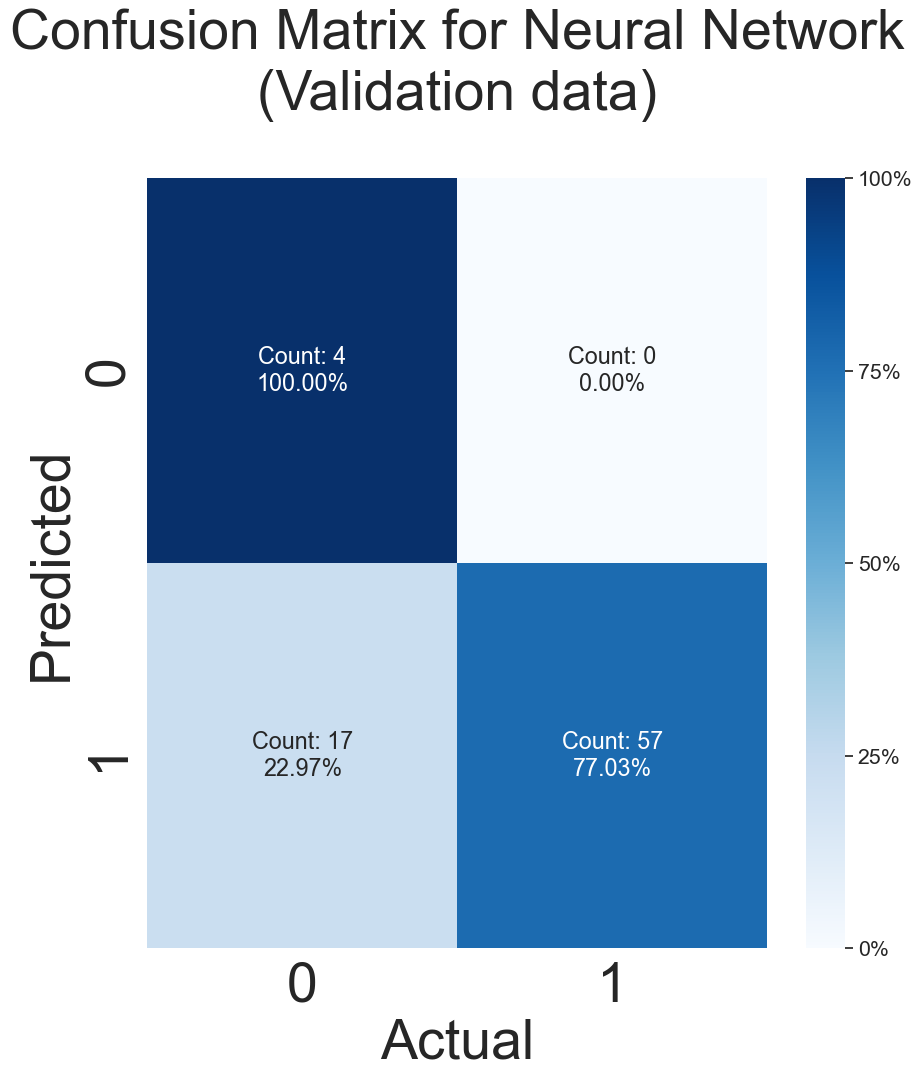

In [ ]:
# Evaluate the model on the entire validation set
predictions = []
true_labels = []
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)


model_evaluation(true_labels, predictions, 'Neural Network', 'Validation')
